<a href="https://colab.research.google.com/github/OUCTheoryGroup/colab_demo/blob/master/spiral_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Spiral classifciation

本次的代码教程里解决 sprial classification 问题，教程有配套的文字版讲解理论，地址为：https://atcold.github.io/pytorch-Deep-Learning/chapters/02-3/   基础一般的同学可以适当看看理论

下面代码是下载绘图函数到本地。（画点的过程中要用到里面的一些函数）

In [0]:
!wget https://raw.githubusercontent.com/Atcold/pytorch-Deep-Learning/master/res/plot_lib.py

引入基本的库，然后初始化重要参数

In [3]:
import random
import torch
from torch import nn, optim
import math
from IPython import display
from plot_lib import plot_data, plot_model, set_default

# 因为colab是支持GPU的，torch 将在 GPU 上运行
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('device: ', device)

# 初始化随机数种子。神经网络的参数都是随机初始化的，
# 不同的初始化参数往往会导致不同的结果，当得到比较好的结果时我们通常希望这个结果是可以复现的，
# 因此，在pytorch中，通过设置随机数种子也可以达到这个目的
seed = 12345
random.seed(seed)
torch.manual_seed(seed)

N = 1000  # 每类样本的数量
D = 2  # 每个样本的特征维度
C = 3  # 样本的类别
H = 100  # 神经网络里隐层单元的数量

device:  cuda:0


初始化 X 和 Y。 X 可以理解为特征矩阵，Y可以理解为样本标签。
结合代码可以看到，X的为一个 NxC 行， D 列的矩阵。C 类样本，每类样本是 N个，所以是 N*C 行。每个样本的特征维度是2，所以是 2列。

在 python 中，调用 zeros 类似的函数，第一个参数是 y方向的，即矩阵的行；第二个参数是 x方向的，即矩阵的列，大家得注意下，不要搞反了。下面结合代码看看 3000个样本的特征是如何初始化的。

In [7]:
X = torch.zeros(N * C, D).to(device)
Y = torch.zeros(N * C, dtype=torch.long).to(device)
for c in range(C):
    index = 0
    t = torch.linspace(0, 1, N) # 在[0，1]间均匀的取10000个数，赋给t
    # 下面的代码不用理解太多，总之是根据公式计算出三类样本（可以构成螺旋形）
    # torch.randn(N) 是得到 N 个均值为0，方差为 1 的一组随机数，注意要和 rand 区分开
    inner_var = torch.linspace( (2*math.pi/C)*c, (2*math.pi/C)*(2+c), N) + torch.randn(N) * 0.2
    
    # 每个样本的(x,y)坐标都保存在 X 里
    # Y 里存储的是样本的类别，分别为 [0, 1, 2]
    for ix in range(N * c, N * (c + 1)):
        X[ix] = t[index] * torch.FloatTensor((math.sin(inner_var[index]), math.cos(inner_var[index])))
        Y[ix] = c
        index += 1

print("Shapes:")
print("X:", X.size())
print("Y:", Y.size())

Shapes:
X: torch.Size([3000, 2])
y: torch.Size([3000])


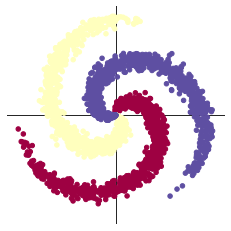

In [9]:
# visualise the data
plot_data(X, Y)

## 1. 构建线性模型分类

In [15]:
learning_rate = 1e-3
lambda_l2 = 1e-5

# nn 包用来创建线性模型
# 每一个线性模型都包含 weight 和 bias
model = nn.Sequential(
    nn.Linear(D, H),
    nn.Linear(H, C)
)
model.to(device) # 把模型放到GPU上

# nn 包含多种不同的损失函数，这里使用的是交叉熵（cross entropy loss）损失函数
criterion = torch.nn.CrossEntropyLoss()

# 这里使用 optim 包进行随机梯度下降(stochastic gradient descent)优化
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=lambda_l2)

# 开始训练
for t in range(1000):
    # 把数据输入模型，得到预测结果
    y_pred = model(X)
    # 计算损失和准确率
    loss = criterion(y_pred, Y)
    score, predicted = torch.max(y_pred, 1)
    acc = (Y == predicted).sum().float() / len(Y)
    print('[EPOCH]: %i, [LOSS]: %.6f, [ACCURACY]: %.3f' % (t, loss.item(), acc))
    display.clear_output(wait=True)

    # 反向传播前把梯度置 0 
    optimizer.zero_grad()
    # 反向传播优化 
    loss.backward()
    # 更新全部参数
    optimizer.step()

[EPOCH]: 999, [LOSS]: 0.864019, [ACCURACY]: 0.500


这里对上面的一些关键函数进行说明:

使用 print(y_pred.shape) 可以看到模型的预测结果，为[3000, 3]的矩阵。每个样本的预测结果为3个，保存在 y_pred 的一行里。值最大的一个，即为预测该样本属于的类别

score, predicted = torch.max(y_pred, 1) 是沿着第二个方向（即X方向）提取最大值。最大的那个值存在 score 中，所在的位置（即第几列的最大）保存在 predicted 中。下面代码把第10行的情况输出，供解释说明

此外，大家可以看到，每一次反向传播前，都要把梯度清零，这个在知乎上有一个回答，大家可以参考：https://www.zhihu.com/question/303070254


In [29]:
print(y_pred.shape)
print(y_pred[10, :])
print(score[10])
print(predicted[10])

torch.Size([3000, 3])
tensor([0.1070, 0.1738, 0.1800], device='cuda:0', grad_fn=<SliceBackward>)
tensor(0.1800, device='cuda:0', grad_fn=<SelectBackward>)
tensor(2, device='cuda:0')


Sequential(
  (0): Linear(in_features=2, out_features=100, bias=True)
  (1): Linear(in_features=100, out_features=3, bias=True)
)


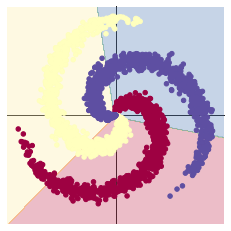

In [14]:
# Plot trained model
print(model)
plot_model(X, Y, model)

上面使用 print(model) 把模型输出，可以看到有两层：
- 第一层输入为 2（因为特征维度为主2），输出为 100；
- 第二层输入为 100 （上一层的输出），输出为 3（类别数）

从上面图示可以看出，线性模型的准确率最高只能达到 50% 左右，对于这样复杂的一个数据分布，线性模型难以实现准确分类。

## 2. 构建两层神经网络分类

In [33]:
learning_rate = 1e-3
lambda_l2 = 1e-5

# 这里可以看到，和上面模型不同的是，在两层之间加入了一个 ReLU 激活函数
model = nn.Sequential(
    nn.Linear(D, H),
    nn.ReLU(),
    nn.Linear(H, C)
)
model.to(device)

# 下面的代码和之前是完全一样的，这里不过多叙述
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=lambda_l2) # built-in L2

# 训练模型，和之前的代码是完全一样的
for t in range(1000):
    y_pred = model(X)
    loss = criterion(y_pred, Y)
    score, predicted = torch.max(y_pred, 1)
    acc = ((Y == predicted).sum().float() / len(Y))
    print("[EPOCH]: %i, [LOSS]: %.6f, [ACCURACY]: %.3f" % (t, loss.item(), acc))
    display.clear_output(wait=True)
    
    # zero the gradients before running the backward pass.
    optimizer.zero_grad()
    # Backward pass to compute the gradient
    loss.backward()
    # Update params
    optimizer.step()

[EPOCH]: 999, [LOSS]: 0.213117, [ACCURACY]: 0.926


Sequential(
  (0): Linear(in_features=2, out_features=100, bias=True)
  (1): ReLU()
  (2): Linear(in_features=100, out_features=3, bias=True)
)


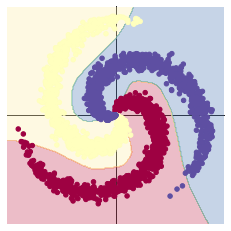

In [35]:
# Plot trained model
print(model)
plot_model(X, Y, model)

大家可以看到，在两层神经网络里加入 ReLU 激活函数以后，分类的准确率得到了显著提高。

里面有原因相信大家在专知课程里面已经学习了，如果不清楚为什么，请再返回去看看专知课程。